In [65]:
import os
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

import re
from konlpy.tag import Mecab
import sentencepiece as spm
import gensim

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

## 1. 데이터 불러오기

In [3]:
tr_path_to_file = "./nsmc/ratings_train.txt"
te_path_to_file = "./nsmc/ratings_test.txt"

train_data = pd.read_csv(tr_path_to_file, sep = "\t")
test_data = pd.read_csv(te_path_to_file, sep = "\t")

    
print("Train Data Size:", len(train_data))
print("Test Data Size:", len(test_data))



print("Example:")
example = zip(train_data["document"][0:100][::20], test_data["document"][0:100][::20])
for ko_sen, en_sen in example: 
    print(">>", ko_sen)
    print(">>", en_sen)
    print("\n")

Train Data Size: 150000
Test Data Size: 50000
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 굳 ㅋ


>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> '13일의 금요일', '나이트메어'시리즈와 함께 가장 많은 시리즈를 양산해냈던 헬레이저 시리즈의 첫편. 작가의 상상력이 돋보이는 작품이며, 갈고리로 사지찢는 고어씬은 지금보더라도 상당히 잔인하고 충격적이다.


>> 단순하면서 은은한 매력의 영화
>> EBS 한국영화특선 해서 봤다.Biff 개막작 선정되서 왤까 궁금 했었는데 봐도 이율 모르겠다...


>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 콩콩~~~~ㅋㄲㅈㅁ


>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..
>> 솔직히 이건 C급 그 이하의 영화이긴 함 ㅎㅎ;




In [4]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터 살펴보기 (시각화)

In [5]:
def text_summary(raw):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in raw:
        length = len(str(sen))
        if min_len > length: 
            min_len = length
        if max_len < length: 
            max_len = length
        sum_len += length
    return min_len, max_len, sum_len // len(raw)

ko_min, ko_max, ko_mean = text_summary(train_data["document"])

print("한국어 문장의 최단 길이:", ko_min)
print("한국어 문장의 최장 길이:", ko_max)
print("한국어 문장의 평균 길이:", ko_mean)

한국어 문장의 최단 길이: 1
한국어 문장의 최장 길이: 146
한국어 문장의 평균 길이: 35


한국어 중에서 가장 긴 문장의 길이 : 146
한국어 중에서 가장 짧은 문장의 길이 : 1


한국어 중에서 가장 많은 데이터 수 : 4472


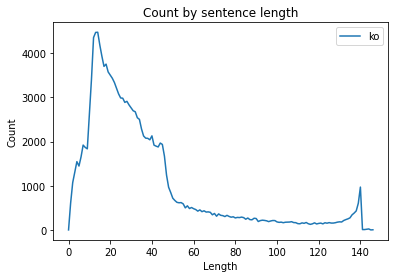

In [6]:
def length_count_vis(copy, col):
    # 문장별 길이를 구합니다
    copy["ko_len"] = copy[col].apply(lambda x : len(str(x)))
    
    ko_max_len = max(copy["ko_len"])
    ko_min_len = min(copy["ko_len"])
    
    print(f'한국어 중에서 가장 긴 문장의 길이 : {ko_max_len}')
    print(f'한국어 중에서 가장 짧은 문장의 길이 : {ko_min_len}')
    print("\n")


    # 길이에 따른 데이터 개수를 구합니다.
    ko_len_count = copy["ko_len"].value_counts().sort_index()

    # 막대그림의 축의 길이를 맞춰줍니다.
    
    ko_count = np.zeros(len(ko_len_count) + 2)

    # 막대그림의 y축
    for i,j in dict(ko_len_count).items():
        ko_count[i] = j

    print(f"한국어 중에서 가장 많은 데이터 수 : {max(ko_len_count)}")

    
    plt.plot(ko_count, label = "ko")
    plt.legend()
    plt.title("Count by sentence length")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()
    return copy

cp_train = train_data.copy()
cp_train = length_count_vis(cp_train, "document")

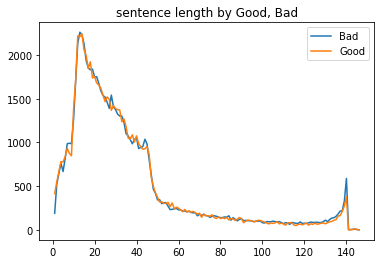

In [7]:
bad_corpus = cp_train.loc[cp_train["label"] == 0, :]
good_corpus = cp_train.loc[cp_train["label"] == 1, :]

bad_len_count = bad_corpus.groupby("ko_len").count().iloc[:,0]
good_len_count = good_corpus.groupby("ko_len").count().iloc[:,0]

plt.plot(bad_len_count, label = "Bad")
plt.plot(good_len_count, label = "Good")
plt.legend()
plt.title("sentence length by Good, Bad")
plt.show()

Text(0.5, 1.0, 'Numbers of class')

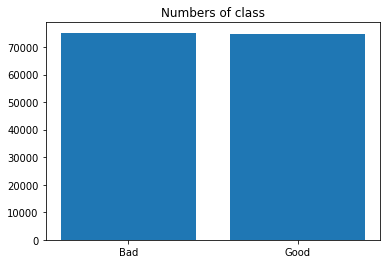

In [8]:
count_label = train_data.groupby("label").count().iloc[:,0]
plt.bar(x = ["Bad", "Good"], height = count_label)
plt.title("Numbers of class")

## 3. 데이터 전처리

- 중복되는 데이터 제거
- 결측치 데이터 제거
- 토큰화 (SentencePiece)

### 3.1 중복 데이터 제거

중복 제거하기 전의 데이터 수 : 150000
중복 제거한 후의 데이터 수 : 146183
한국어 중에서 가장 긴 문장의 길이 : 146
한국어 중에서 가장 짧은 문장의 길이 : 1


한국어 중에서 가장 많은 데이터 수 : 4431


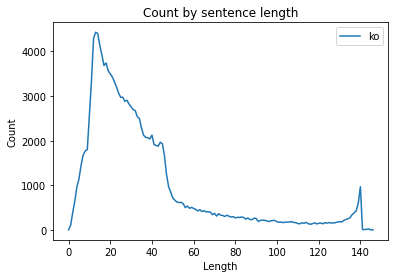

In [9]:
print(f"중복 제거하기 전의 데이터 수 : {len(cp_train)}")
cp_train = cp_train.drop_duplicates("document")
cp_train = cp_train.reset_index()
print(f"중복 제거한 후의 데이터 수 : {len(cp_train)}")
cp_train = length_count_vis(cp_train, "document")

### 3.2 결측치 데이터 제거

In [10]:
cp_train = cp_train.replace(["",'', " ", ' '], np.nan)
cp_train.isnull().sum()

index       0
id          0
document    1
label       0
ko_len      0
dtype: int64

In [11]:
print(f"결측치 제거하기 전의 데이터 수 : {len(cp_train)}")
cp_train = cp_train.dropna()
print(f"결측치 제거한 후의 데이터 수 : {len(cp_train)}")

결측치 제거하기 전의 데이터 수 : 146183
결측치 제거한 후의 데이터 수 : 146182


### 3.3 토큰화 (SentencePiece)

In [13]:
tr_temp_file = "./model/nsmc_bpe_train.tmp"

with open(tr_temp_file, 'w') as f:
    for row in cp_train["document"]:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

vocab_size = 8000
spm.SentencePieceTrainer.Train('--input={} --model_prefix=nsmc_bpe_spm --vocab_size={} --model_type=bpe'.format(tr_temp_file, vocab_size))  

s = spm.SentencePieceProcessor()
s.Load('nsmc_bpe_spm.model')

True

In [14]:
max_len = max(cp_train["ko_len"])
id_document = cp_train["document"].apply(lambda x : s.EncodeAsIds(str(x)))
pad_document = pad_sequences(id_document, maxlen = max_len, padding = "post")
pad_document.shape

(146182, 146)

## 4. 분류 모델 구축

### 4.1 모델 하이퍼파라미터 지정

In [15]:
batch_size = 128
hidden_size = 64
word_vector_dim = 200
epochs = 1

### 4.2 훈련셋, 검증셋 분리

In [16]:
x_data = pad_document
y_data = cp_train["label"].to_numpy().reshape(-1, 1)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, 
                                                  test_size = 0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((116945, 146), (29237, 146), (116945, 1), (29237, 1))

### 4.3 텐서플로우 데이터셋으로 변환

In [17]:
def tensorflow_dataset(input_x, input_y, buffer_size, batch_size):
    tf_data = tf.data.Dataset.from_tensor_slices((input_x, input_y))
    tf_data = tf_data.shuffle(buffer_size)
    tf_data = tf_data.repeat()
    tf_data = tf_data.batch(batch_size)
    tf_data = tf_data.prefetch(buffer_size = -1)
    return tf_data 

train_buffer_size = len(x_train)
val_buffer_size = len(x_val)
tf_train = tensorflow_dataset(x_train, y_train, 
                              train_buffer_size, batch_size)
tf_val = tensorflow_dataset(x_val, y_val, 
                              val_buffer_size, batch_size)

### 4.4 이진분류 모델 설계 및 컴파일

In [18]:
class NSMC_model(tf.keras.Model):
    
    def __init__(self, vocab_size, embedd_size, hidden_size):
        super(NSMC_model, self).__init__()
        self.embedding = tf.keras.layers.Embedding(input_dim = vocab_size,
                                                   output_dim = embedd_size)
        self.BiLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hidden_size, return_sequences = True))
        self.BN = tf.keras.layers.BatchNormalization()
        self.dense = tf.keras.layers.Dense(16, activation = "relu")
        self.out = tf.keras.layers.Dense(1, activation = "sigmoid")
        
    def call(self, x):
        x = self.embedding(x)
        x = self.BiLSTM(x)
        x = self.BN(x)
        x = self.dense(x)
        x = self.out(x)
        return x

model = NSMC_model(vocab_size, word_vector_dim, hidden_size)
model.compile(optimizer="adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

### 4.5 모델 학습

In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience = 5)

In [20]:
history = model.fit(tf_train, 
                    steps_per_epoch = train_buffer_size // batch_size,
                    validation_data = tf_val,
                    validation_steps = val_buffer_size // batch_size,
                    epochs = epochs,
                    callbacks = [es, lr_reduce]
                   )

913/913 [==============================] - 73s 75ms/step - loss: 0.4751 - accuracy: 0.7523 - val_loss: 0.3844 - val_accuracy: 0.8480


In [21]:
model.summary()

Model: "nsmc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1600000   
_________________________________________________________________
bidirectional (Bidirectional multiple                  135680    
_________________________________________________________________
batch_normalization (BatchNo multiple                  512       
_________________________________________________________________
dense (Dense)                multiple                  2064      
_________________________________________________________________
dense_1 (Dense)              multiple                  17        
Total params: 1,738,273
Trainable params: 1,738,017
Non-trainable params: 256
_________________________________________________________________


### 5. 모델 검증 및 평가

In [22]:
def show_performance(history):
    loss, acc, val_loss, val_acc = history.history.values()
    plt.plot(loss, label = "loss")
    plt.plot(acc, label = "acc")
    plt.plot(val_loss, label = "val_loss")
    plt.plot(val_acc, label = "val_acc")
    plt.title("Model Performance")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
show_performance(history)

ValueError: too many values to unpack (expected 4)

In [23]:
model.evaluate(x_val, y_val)

914/914 [==============================] - 15s 16ms/step - loss: 0.3842 - accuracy: 0.8481


[0.3841555118560791, 0.848077118396759]

In [47]:
y_preds = model.predict(x_val)
y_pred_mean = np.mean(y_preds, axis= 1)
y_pred = np.where(y_pred_mean < 0.5, 0, 1)

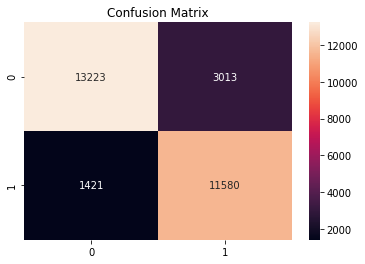

In [64]:
sns.heatmap(confusion_matrix(y_pred, y_val), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()